### Time Series Analysis
Time Series Forecasting Models are models capable of predicing future values based on previously observed values. They are widely used for Non Stationary Data i.e whose Mean and Standard Devitation are not constant over time

There are four main components of Time Series Analysis:
1. Trend
2. Seasonality
3. Irregularity
4. Cyclic

### ARIMA Model: Auto Regressive Integrated Moving Average Model 
- ARIMA uses a number of lagged observations of time series to forecast observations
- These models rely on regressing a variable on past values
- ARIMA relies on AutoRegression, which is a process of regressing a variable on past values of itself
- Autocorrelations gradually decay and estimate the degree to which white noise characterizes a series of data

##### 2 Properties of ARIMA
  - `Integrated Property`: ARIMA models have a degree of differencing which eliminates seasonality
  - `Moving Average Property`: Moving average (MA) removes non-determinism or random movements from a time series

##### 3 Parameters of ARIMA
  - `p`: parameter associated with the auto-regressive aspect of the model, which incorporates past values
  - `d`: parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series
  - `q`: size/width of moving average

##### ARIMA Model works on the following assumptions
   - The data series is stationary i.e the mean and variance does not vary with time. This can be performed by using log transformation or differencing the series
   - The data provided as input must be univariate series, since ARIMA uses past values to predict the future values

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tools.eval_measures import rmse
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import lag_plot
import itertools
from statsmodels.tsa.arima_model import ARIMA, ARMA
import warnings
warnings.filterwarnings('ignore')

### 1. Understanding & Processing Data 

In [16]:
df = pd.read_csv("/Users/arnavgupta/Desktop/NUS Fintech Society/2. Time Series Analysis/Stock Price Data.csv")
df = df[['Date', 'Close']]
df1 = pd.to_datetime(df.Date)
df1 = df.set_index("Date")
print(df1.head())

                Close
Date                 
31/12/2009  36.998249
4/01/2010   37.234500
5/01/2010   37.162500
6/01/2010   37.133251
7/01/2010   37.059000


#### `Auto Correlation`

Before building the model, let's evaluate if there exists auto-correlation in the data, as having strong Auto-correlation suggests that ARIMA is a good model to be applied to a type of data.

**Auto Correlation** : Is the correlation of a signal with a delayed copy of itself as a function of delay
It is the similarity between observations as a function of time lag between them

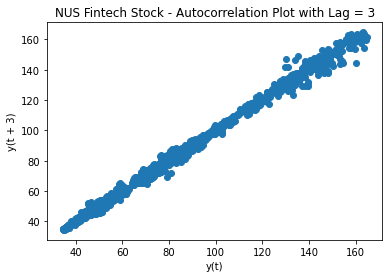

In [17]:
plt.figure("NUS Fintech Stock - Autocorrelation Plot with Lag = 3")
lag_plot(df['Close'], lag=3)
plt.title("NUS Fintech Stock - Autocorrelation Plot with Lag = 3")
plt.show()

We can see from the above plot that there exists a strong correlation between the two variables.
This explains the auto-correlation in the data and supports the use of ARIMA in evaluating this case


#### `Time Series Analysis`

<Figure size 432x288 with 0 Axes>

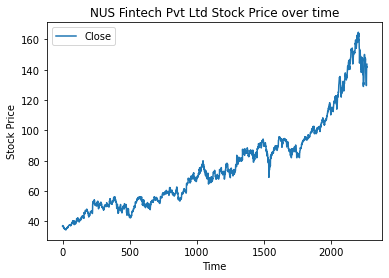

In [18]:
plt.figure("NUS Fintech Pvt Ltd Stock Price over time")
df.plot(style="-")
plt.title("NUS Fintech Pvt Ltd Stock Price over time")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

The above graph gives us a snapshot of NUS Fintech Pvt Ltd's stock price over time (2009 - 2018). 

Seasonality Check: It shows an upwards trend suggesting the data is not stationary. Hence, we need to perform differencing to remove any trends or seasonal structures


### 2. Model Preparation 

#### `Performing Differencing and Augmented Dickey-Fuller Test `

In [19]:
from statsmodels.tsa.stattools import adfuller
df1_diff = df1.diff().dropna()
print("p-value:", adfuller(df1_diff.dropna())[1])

p-value: 4.366596702701818e-15


Upon using the Augmented Dickey-Fuller Test, we can identify the p value to be well below 0.05. This allows us to reject the null hypothesis, indicating the series is stationary

Since we are able to attain stationarity in the first order differencing, we do not need to difference it further more. Hence, d = 1

#### `Auto Correlation and Partial Correlation Functions`

We will be plotting the Auto Correlation and Partial Correlation Functions to identify the p and q value for the ARIMA Model

 - **ACF Plot** is merely a bar chart of the coefficients of correlation between a time series and lags of itself.
 - **PACF Plot** is a plot of the partial correlation coefficients between the series and lags of itself
 


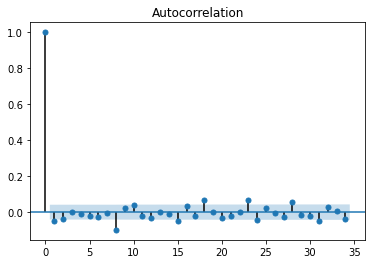

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df1_diff)
plt.show()

The ACF Plot shows that there is only one lag that goes beyond the critically defined boundary, allowing us to use the value of q as 1

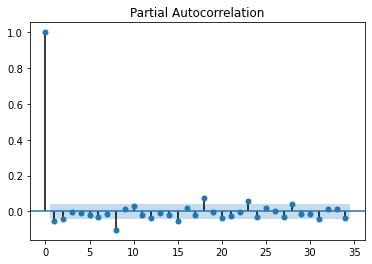

In [21]:
plot_pacf(df1_diff)
plt.show() 

The PACF Plot shows that there is only one lag that goes beyond the critically defined boundary, allowing us to use the value of p as 1

### 3. Data Modelling & Forecasting 

In [22]:
model = ARIMA(df1, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3694.134
Method:                       css-mle   S.D. of innovations              1.237
Date:                Mon, 21 Sep 2020   AIC                           7396.268
Time:                        00:21:25   BIC                           7419.168
Sample:                             1   HQIC                          7404.624
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0468      0.018      2.623      0.009       0.012       0.082
ar.L1.D.Close     0.8561      0.058     14.803      0.000       0.743       0.970
ma.L1.D.Close    -0.9014      0.049    -

We can see from the summary that ar.L1.D.Close and ma.l1.D.Close, both have their P values to be highly significant (<0.05)

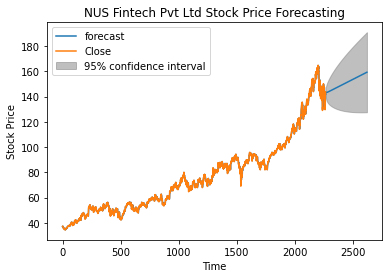

In [23]:
model_fit.plot_predict(start=1, end=len(df1)+355)
plt.title("NUS Fintech Pvt Ltd Stock Price Forecasting")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

### 4. Evaluation of ARIMA Model

#### `Evaluating the optimisation of ARIMA Model through the grid search method`

In [24]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
warnings.filterwarnings("ignore")
aic= []
parameters = []
for param in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(df1, order=param, enforce_stationarity=True, enforce_invertibility=True)
        results = mod.fit()
        aic.append(results.aic)
        parameters.append(param)
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue
index_min = min(range(len(aic)), key=aic.__getitem__)

print('The optimal model is: ARIMA{} - AIC{}'.format(parameters[index_min], aic[index_min]))

ARIMA(0, 0, 0) - AIC:26403.07723981226
ARIMA(0, 0, 1) - AIC:23316.6137574957
ARIMA(0, 0, 2) - AIC:20546.394488537426
ARIMA(0, 1, 0) - AIC:7410.763823302084
ARIMA(0, 1, 1) - AIC:7406.677556915602
ARIMA(0, 1, 2) - AIC:7405.498765079765
ARIMA(0, 2, 0) - AIC:9085.662962258579
ARIMA(0, 2, 1) - AIC:7414.961099250268
ARIMA(0, 2, 2) - AIC:7410.610718328427
ARIMA(1, 0, 0) - AIC:7424.796115865703
ARIMA(1, 0, 1) - AIC:7420.72039808975
ARIMA(1, 0, 2) - AIC:7419.548017571186
ARIMA(1, 1, 0) - AIC:7407.145373578546
ARIMA(1, 1, 1) - AIC:7400.58778255563
ARIMA(1, 1, 2) - AIC:7407.499871847448
ARIMA(1, 2, 0) - AIC:8419.31558284108
ARIMA(1, 2, 1) - AIC:7411.104736181322
ARIMA(1, 2, 2) - AIC:7418.8781938897055
ARIMA(2, 0, 0) - AIC:7421.186976123731
ARIMA(2, 0, 1) - AIC:7428.714304885595
ARIMA(2, 0, 2) - AIC:7421.453841580364
ARIMA(2, 1, 0) - AIC:7405.560491773151
ARIMA(2, 1, 1) - AIC:7407.56044949985
ARIMA(2, 1, 2) - AIC:7403.966804727219
ARIMA(2, 2, 0) - AIC:8101.58430105248
ARIMA(2, 2, 1) - AIC:7409.305

*The following grid search method allows us to assure that the order of parameters has been optimised for the best performing ARIMA model, by choosing (1,1,1)*

### 5. Extracting Predicted Results

Based on our Model, we have predicted the stock price from 2/1/19 to 29/5/20. It can be extracted here for a preview

In [25]:
my_submission = pd.read_excel("~/Desktop/NUS Fintech Society/2. Time Series Analysis/My Submission .xlsx")
ms_1 = my_submission.head()
ms_2 = my_submission.tail()
print(ms_1)
print(ms_2)

        Date       Close
0 2019-01-02  143.588172
1 2019-01-03  143.522280
2 2019-01-04  143.472602
3 2019-01-07  143.436805
4 2019-01-08  143.412892
          Date       Close
350 2020-05-22  159.190082
351 2020-05-26  159.236898
352 2020-05-27  159.283713
353 2020-05-28  159.330529
354 2020-05-29  159.377344


We can compare the first 5 entries of our prediction to the last 5 entries of our prediction. This allows us to draw an inference as to how well the stock price has changed over time

In [26]:
rate_of_change = (159.377344 - 143.588172)/(143.588172)
print(rate_of_change*100)

10.996150852871091


This prediction shows a 11 % increase in the stock price over 16 months. This evaluates to around 8.25 % increase in stock price annually.